<a href="https://colab.research.google.com/github/ai-fast-track/timeseries/blob/master/nbs/cam_tutorial_ECG200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial - 2: Model interpretation using CAM and GRAD-CAM
> CAM and GRAD-CAM for the ECG200 univariate time series dataset

In [ ]:
# Run this cell to install the latest version of fastai2 shared on github
!pip install git+https://github.com/fastai/fastai2.git

In [ ]:
# Run this cell to install the latest version of fastcore shared on github
!pip install git+https://github.com/fastai/fastcore.git

In [ ]:
# Run this cell to install the latest version of timeseries shared on github
!pip install git+https://github.com/ai-fast-track/timeseries.git

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai2.basics import *

In [ ]:
# hide
# Only for Windows users because symlink to `timeseries` folder is not recognized by Windows
import sys
sys.path.append("..")

In [ ]:
from timeseries.all import *

# Class Activation Map (CAM) and Grafient-CAM (GRAD-CAM) Tutorial

## ECG Dataset
> This dataset was formatted by R. Olszewski as part of his thesis
“Generalized feature extraction for structural	pattern recognition
in time-series data,” at Carnegie Mellon University, 2001. Each
series traces the electrical activity recorded during one
heartbeat. The two classes are a normal heartbeat and a Myocardial
Infarction. 	

![](images/ECG200.png)

## Training a model

In [ ]:
# You can choose any multivariate or univariate dataset listed the `data.py` file
path = unzip_data(URLs_TS.UNI_ECG200)

In [ ]:
dsname =  'ECG200' # 'ChlorineConcentration', 'GunPoint'
fname_train = f'{dsname}_TRAIN.arff'
fname_test = f'{dsname}_TEST.arff'
fnames = [path/fname_train, path/fname_test]
fnames

[Path('/home/farid/.fastai/data/ECG200/ECG200_TRAIN.arff'),
 Path('/home/farid/.fastai/data/ECG200/ECG200_TEST.arff')]

In [ ]:
# num_workers=0 is for Windows platform
dls = TSDataLoaders.from_files(bs=64,fnames=fnames, num_workers=0) 

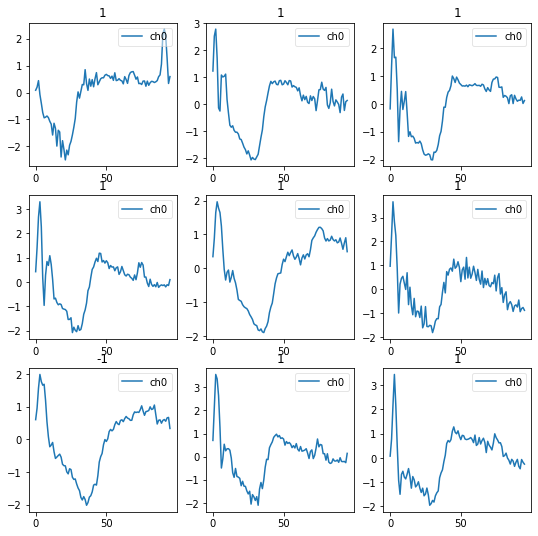

In [ ]:
dls.show_batch(chs=range(0,12,3))

In [ ]:
learn = ts_learner(dls)
learn.fit_one_cycle(25, lr_max=1e-3) 

epoch,train_loss,valid_loss,accuracy,time
0,1.564570,0.692637,0.575000,00:01
1,1.462592,0.693195,0.400000,00:01
2,1.268981,0.694528,0.425000,00:01
3,1.179913,0.695696,0.425000,00:01
4,1.036617,0.697044,0.425000,00:01
5,0.924462,0.699962,0.425000,00:01
6,0.836526,0.701950,0.425000,00:01
7,0.763301,0.703177,0.425000,00:01
8,0.704392,0.708641,0.425000,00:01
9,0.654548,0.709012,0.425000,00:01


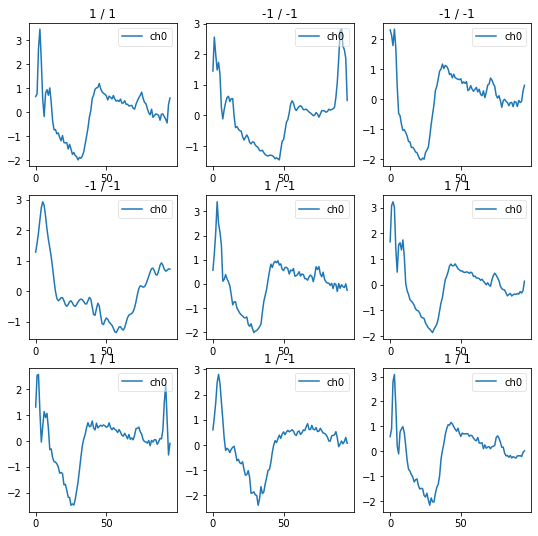

In [ ]:
learn.show_results()

In [ ]:
model = learn.model.eval()

In [ ]:
model[5]

SequentialEx(
  (layers): ModuleList(
    (0): InceptionModule(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
      (convs): ModuleList(
        (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
        (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
        (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      )
      (maxpool_bottleneck): Sequential(
        (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (1): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
      (bn_relu): Sequential(
        (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
    )
    (1): Shortcut(
      (act_fn): ReLU(inplace=True)
      (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
dls.vocab

(#2) ['-1','1']

## Decoding class labels 

In [ ]:
# i2o() function
# Converting CategoryTensor label into the human-readable label
lbl_dict = dict([
    (0, 'Normal'),   
    (1, 'Myocardial Infarction')]
)
def i2o(y):
    return lbl_dict.__getitem__(y.data.item())
    # return lbl_dict.__getitem__(int(dls.tfms[1][1].decodes(y)))

## Creating a customized batch :  list of 2 items 

> Note: This is not a batch in literal sense as used using `DataLoader.one_batch()` method. It just a list of some dataset items
- batch\[0\]: corresponds to `Normal EKG`
- batch\[1\]: corresponds to `Myocardial Infarction`

In [ ]:
idxs = [0,2]
batch = get_batch(dls.train.dataset, idxs)

idxs = [0,3]
batch = get_batch(dls.train.dataset, idxs)
# len(batch), type(batch)

## Plotting CAM for several dataset items in one shared figure 
> Example: the function expects a list of `items` and plots CAM for the provided items list.

### Class Activation Map (CAM)
This option calculates the activations values at the selected layer.By default the activations curves are plotted in one single figure.

`func_cam=cam_acts` : activation function name (activation values at the chosen model layer). It is the default value
 
The figure title `[Gun - Point] - CAM - mean` should be read as follow:
- `Gun`     : class of the first curve
- `Point`   : class of the second curve
- `CAM`     : activation function name (activation values at the chosen model layer)
- `mean`    : type of reduction (read the explanation below: 4 types of reductions)

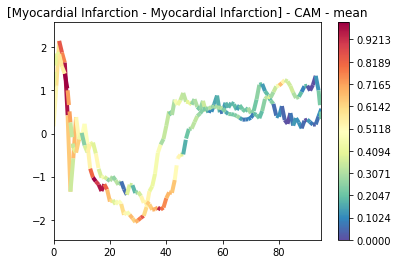

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=cam_acts) # default:  func_cam=cam_acts, multi_fig=False, figsize=(6,4)

### Plot each time series curve in a separate figure  

### Using CAM and `CMAP.seismic` palette

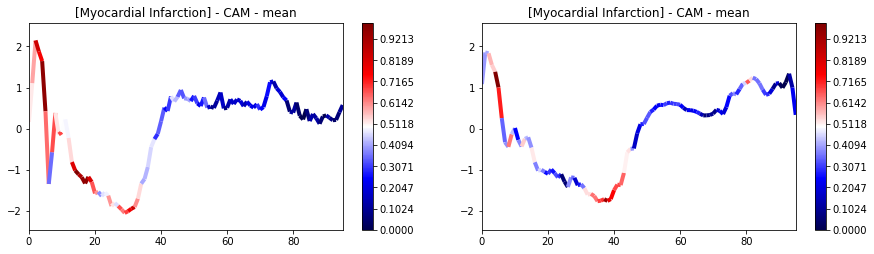

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, multi_fig=True, cmap=CMAP.seismic) # default: func_cam=cam_acts, figsize=(13,4)

### Using GRAD-CAM and `CMAP.seismic` palette
> Notice the difference in activations values between CAM and GRAD-CAM

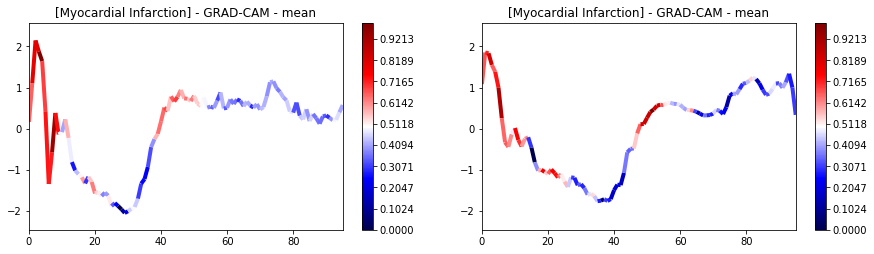

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts, multi_fig=True, cmap=CMAP.seismic) 

### Superimposed curves give another insight in comparing the 2 time series

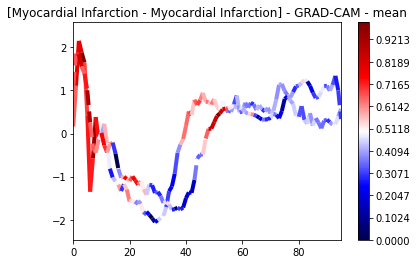

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts, cmap=CMAP.seismic)

### Plotting scattered lines

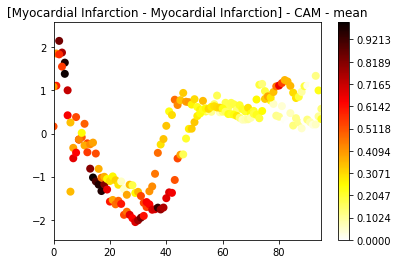

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, linewidth=2, scatter=True, cmap=CMAP.hot_r)

## Plotting CAM for a batch of items 
> We can also feed the show_cam() a full batch return straight from `DataLoaders` `one_batch() method as shown here below

### Creating a batch of 5 items

In [ ]:
dls.train = dls.train.new(bs=5)
batch = dls.train.one_batch()
# batch

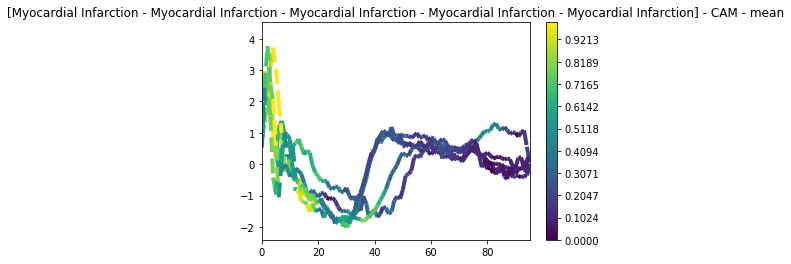

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap=CMAP.viridis)

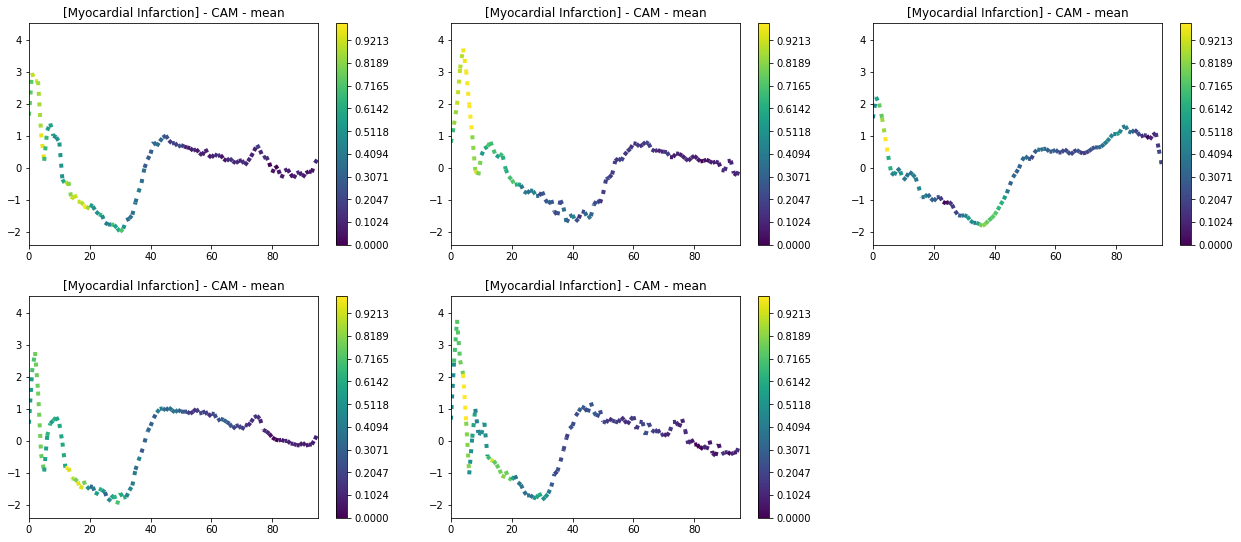

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, cmap=CMAP.viridis, multi_fig=True, figsize=(18, 8), linestyles='dotted')

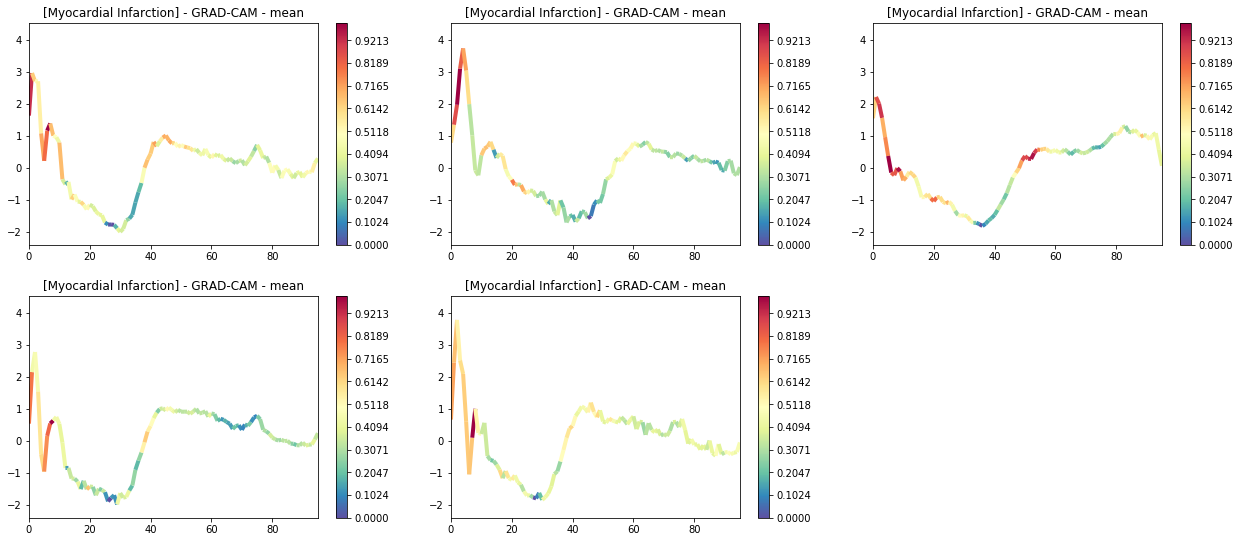

In [ ]:
show_cam(batch, model, layer=5, i2o=i2o, func_cam=grad_cam_acts, multi_fig=True, figsize=(18, 8))

## Plotting CAM for a single dataset item 

> We can also feed the `show_cam()` a single item

> There are also `164` different palettes. Check out `CMAP` class and its autocompletion

> line styles : 'solid' | 'dashed' | 'dashdot' | 'dotted'


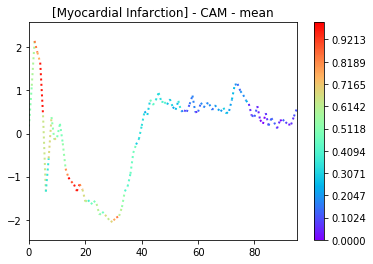

In [ ]:
show_cam(dls.train.dataset[0], model, layer=5, i2o=i2o, cmap='rainbow', linewidth=2, linestyles='dotted')

![](images/montreal-pont-jacques-cartier.jpg)
